In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import datetime
import iisignature as sig
from tqdm import tqdm
from plotly.offline import init_notebook_mode, iplot
from plot_metric.functions import BinaryClassification
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.svm import TimeSeriesSVC
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib


init_notebook_mode(connected=True) ## plotly init
n_splits = 5

In [2]:
#data import
filenames_list = os.listdir('SMNI_CMI_TRAIN/Train') ## list of file names in the directory
EEG_data = pd.DataFrame({}) ## create an empty df that will hold data from each file
print(len(filenames_list))
for file_name in tqdm(filenames_list):
    temp_df = pd.read_csv('SMNI_CMI_TRAIN/Train/' + file_name) ## read from the file to df
    EEG_data = EEG_data.append(temp_df) ## add the file data to the main df

EEG_data = EEG_data.drop(['Unnamed: 0'], axis=1) ## remove the unused column
EEG_data.loc[EEG_data['matching condition'] == 'S2 nomatch,', 'matching condition'] =  'S2 nomatch' ## remove comma sign from stimulus name

468


  0%|          | 0/468 [00:00<?, ?it/s]C:\Users\yousi\AppData\Local\Temp\ipykernel_24420\3614737585.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  0%|          | 1/468 [00:00<03:28,  2.24it/s]C:\Users\yousi\AppData\Local\Temp\ipykernel_24420\3614737585.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yousi\AppData\Local\Temp\ipykernel_24420\3614737585.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yousi\AppData\Local\Temp\ipykernel_24420\3614737585.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yousi\AppData\Local\Temp\ipykernel_24420\3614737585.py:7: FutureWarning:

The frame.append method

In [3]:
#example try for create train set
temp_df = pd.read_csv('SMNI_CMI_TRAIN/Train/Data1.csv')
print(temp_df['subject identifier'][0])
print(temp_df["matching condition"][0])
print(np.array(temp_df["sensor value"]).reshape([64,256]))

a
S1 obj
[[ -8.921  -8.433  -2.574 ...   4.262   5.727   8.169]
 [  0.834   3.276   5.717 ...   2.787   9.623  13.041]
 [-19.847 -12.522   1.149 ...   7.009  11.403  12.868]
 ...
 [ -0.478  -0.966  -0.966 ...   4.405   3.916   2.94 ]
 [ -8.901  -7.924  -3.042 ...   4.771   6.236   8.677]
 [ -5.636  -2.706   1.689 ...  15.849  16.337  14.872]]


In [4]:
ts_scaler = TimeSeriesScalerMinMax()
scaler = StandardScaler()

In [5]:
#S1: S1 obj - a single object shown;
s1 = 0
#S12: S2 nomatch - object 2 shown in a non matching condition (S1 differed from S2)
s12 = 0
#S21: S2 match - object 2 shown in a matching condition (S1 was identical to S2),
s21 = 0
s1_X_train_unscaled = np.zeros((160,256,64))
s1_y_train = np.zeros(160)
s21_X_train_unscaled = np.zeros((159,256,64))
s21_y_train = np.zeros(159)
s12_X_train_unscaled = np.zeros((149,256,64))
s12_y_train = np.zeros(149)


classifier = {'a':1,'c':0}

filenames_list = os.listdir('SMNI_CMI_TRAIN/Train') ## list of file names in the directory
EEG_data = pd.DataFrame({}) ## create an empty df that will hold data from each file
print(len(filenames_list))
for file_name in tqdm(filenames_list):
    temp_df = pd.read_csv('SMNI_CMI_TRAIN/Train/' + file_name) ## read from the file to df
    if temp_df["matching condition"][0] == "S1 obj":
        s1_X_train_unscaled[s1] = np.transpose(np.array(temp_df["sensor value"]).reshape([64,256]))
        s1_y_train[s1] = classifier[temp_df['subject identifier'][0]]
        s1 += 1
    if temp_df["matching condition"][0] == "S2 match":
        s21_X_train_unscaled[s21] = np.transpose(np.array(temp_df["sensor value"]).reshape([64,256]))
        s21_y_train[s21] = classifier[temp_df['subject identifier'][0]]
        s21 += 1
    if temp_df["matching condition"][0] == "S2 nomatch,":
        s12_X_train_unscaled[s12] = np.transpose(np.array(temp_df["sensor value"]).reshape([64,256]))
        s12_y_train[s12] = classifier[temp_df['subject identifier'][0]]
        s12 += 1

s1_X_train = ts_scaler.fit_transform(s1_X_train_unscaled)
s21_X_train = ts_scaler.fit_transform(s21_X_train_unscaled)
s12_X_train = ts_scaler.fit_transform(s12_X_train_unscaled)

print(s1)
print(s21)
print(s12)

468


100%|██████████| 468/468 [00:05<00:00, 89.14it/s]


160
159
149


In [6]:
#t1: S1 obj - a single object shown;
t1 = 0
#t12: S2 nomatch - object 2 shown in a non matching condition (S1 differed from S2)
t12 = 0
#t21: S2 match - object 2 shown in a matching condition (S1 was identical to S2),
t21 = 0
t1_X_test_unscaled = np.zeros((160,256,64))
t1_y_test = np.zeros(160)
t21_X_test_unscaled = np.zeros((160,256,64))
t21_y_test = np.zeros(160)
t12_X_test_unscaled = np.zeros((160,256,64))
t12_y_test = np.zeros(160)


classifier = {'a':1,'c':0}

filenames_list = os.listdir('SMNI_CMI_TEST') ## list of file names in the directory
EEG_data = pd.DataFrame({}) ## create an empty df that will hold data from each file
print(len(filenames_list))
for file_name in tqdm(filenames_list):
    if file_name == "Test":
        pass
    else:
        temp_df = pd.read_csv('SMNI_CMI_TEST/' + file_name) ## read from the file to df
        if temp_df["matching condition"][0] == "S1 obj":
            t1_X_test_unscaled[t1] = np.transpose(np.array(temp_df["sensor value"]).reshape([64,256]))
            t1_y_test[t1] = classifier[temp_df['subject identifier'][0]]
            t1 += 1
        if temp_df["matching condition"][0] == "S2 match":
            t21_X_test_unscaled[t21] = np.transpose(np.array(temp_df["sensor value"]).reshape([64,256]))
            t21_y_test[t21] = classifier[temp_df['subject identifier'][0]]
            t21 += 1
        if temp_df["matching condition"][0] == "S2 nomatch,":
            t12_X_test_unscaled[t12] = np.transpose(np.array(temp_df["sensor value"]).reshape([64,256]))
            t12_y_test[t12] = classifier[temp_df['subject identifier'][0]]
            t12 += 1

t1_X_test = ts_scaler.fit_transform(t1_X_test_unscaled)
t21_X_test = ts_scaler.fit_transform(t21_X_test_unscaled)
t12_X_test = ts_scaler.fit_transform(t12_X_test_unscaled)

print(t1)
print(t21)
print(t12)

481


100%|██████████| 481/481 [00:05<00:00, 92.55it/s]


160
160
160


In [8]:
start = datetime.datetime.now()
# pipeline = GridSearchCV(
#     Pipeline([
#             ('knn', KNeighborsTimeSeriesClassifier())
#     ]),
#     {'knn__n_neighbors': [3, 4, 5, 6, 7, 8, 10, 12, 15, 20, 25], 'knn__weights': ['uniform', 'distance']},
#     cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0),
#     n_jobs=-1
# )
# pipeline.fit(s1_X_train, s1_y_train)
# joblib.dump(pipeline.best_estimator_, 'ts_knn_1.pkl')
# y_pred_proba = pipeline.predict_proba(t1_X_test)[:,1]
# y_pred = pipeline.predict(t1_X_test)

loaded_model = joblib.load(open('ts_knn_1.pkl', 'rb'))
y_pred_proba = loaded_model.predict_proba(t1_X_test)[:,1]
y_pred = loaded_model.predict(t1_X_test)
score = roc_auc_score(t1_y_test, y_pred_proba)
#
end = datetime.datetime.now()
print(score)
print(end-start)

0.8503125
0:01:42.971061


In [9]:
clf = TimeSeriesSVC(C=1.0, kernel="gak", n_jobs=10)
clf.fit(s1_X_train, s1_y_train)
print(clf.score(t1_X_test, t1_y_test))

0.75


In [10]:
s1_sig_train = sig.sig(s1_X_train, 2)
s1_sig_test = sig.sig(t1_X_test, 2)

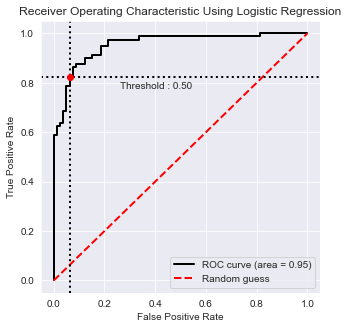

score is 0.954375


In [11]:
clf = LogisticRegression()
clf.fit(s1_sig_train, s1_y_train)
y_pred_proba = clf.predict_proba(s1_sig_test)[:,1]
y_pred = clf.predict(s1_sig_test)

bc = BinaryClassification(t1_y_test, y_pred_proba, labels=["Class 0", "Class 1"])
# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.title("Receiver Operating Characteristic Using Logistic Regression")
plt.show()
score = roc_auc_score(t1_y_test, y_pred_proba)
print("score is " + str(score))

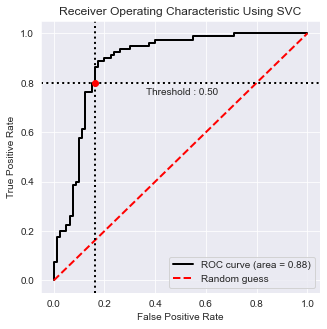

score is 0.88265625


In [12]:
clf = SVC(probability=True)
clf.fit(s1_sig_train, s1_y_train)
y_pred_proba = clf.predict_proba(s1_sig_test)[:,1]
y_pred = clf.predict(s1_sig_test)
bc = BinaryClassification(t1_y_test, y_pred_proba, labels=["Class 0", "Class 1"])
# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.title("Receiver Operating Characteristic Using SVC")
plt.show()
score = roc_auc_score(t1_y_test, y_pred_proba)
print("score is " + str(score))

In [13]:
for i in tqdm(range(3,20)):
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=10)
    knn.fit(s1_sig_train, s1_y_train)
    y_pred = knn.predict(s1_sig_test)
    print(accuracy_score(t1_y_test, y_pred))

  6%|▌         | 1/17 [00:00<00:01,  9.49it/s]

0.79375
0.74375
0.8
0.725
0.75625
0.725
0.75625
0.725
0.75625
0.71875


100%|██████████| 17/17 [00:00<00:00, 64.99it/s]

0.74375
0.7125
0.73125
0.70625
0.70625
0.70625
0.70625


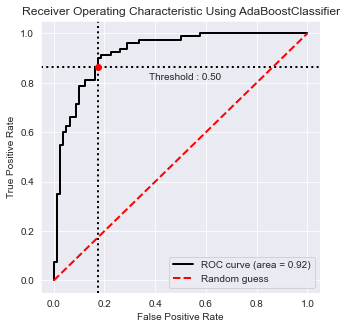

score is 0.923125


In [14]:
clf = AdaBoostClassifier()
clf.fit(s1_sig_train, s1_y_train)
y_pred_proba = clf.predict_proba(s1_sig_test)[:,1]
y_pred = clf.predict(s1_sig_test)

bc = BinaryClassification(t1_y_test, y_pred_proba, labels=["Class 0", "Class 1"])
# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.title("Receiver Operating Characteristic Using AdaBoostClassifier")
plt.show()
score = roc_auc_score(t1_y_test, y_pred_proba)
print("score is " + str(score))

In [15]:
from tqdm import tqdm
for i in tqdm(range(3,20)):
    knn = KNeighborsTimeSeriesClassifier(n_neighbors=i, n_jobs=10)
    knn.fit(s12_X_train, s12_y_train)
    print(knn.score(t12_X_test,t12_y_test))

  6%|▌         | 1/17 [00:06<01:47,  6.70s/it]

0.8125


 12%|█▏        | 2/17 [00:13<01:39,  6.67s/it]

0.7875


 18%|█▊        | 3/17 [00:19<01:33,  6.65s/it]

0.8


 24%|██▎       | 4/17 [00:26<01:26,  6.64s/it]

0.8125


 29%|██▉       | 5/17 [00:33<01:19,  6.65s/it]

0.78125


 35%|███▌      | 6/17 [00:39<01:13,  6.64s/it]

0.775


 41%|████      | 7/17 [00:46<01:06,  6.64s/it]

0.78125


 47%|████▋     | 8/17 [00:53<00:59,  6.66s/it]

0.8


 53%|█████▎    | 9/17 [00:59<00:53,  6.65s/it]

0.80625


 59%|█████▉    | 10/17 [01:06<00:46,  6.65s/it]

0.7875


 65%|██████▍   | 11/17 [01:13<00:39,  6.64s/it]

0.80625


 71%|███████   | 12/17 [01:19<00:33,  6.65s/it]

0.7875


 76%|███████▋  | 13/17 [01:26<00:26,  6.65s/it]

0.79375


 82%|████████▏ | 14/17 [01:33<00:19,  6.65s/it]

0.79375


 88%|████████▊ | 15/17 [01:39<00:13,  6.63s/it]

0.8125


 94%|█████████▍| 16/17 [01:46<00:06,  6.64s/it]

0.7875


100%|██████████| 17/17 [01:53<00:00,  6.65s/it]

0.775


In [16]:
start = datetime.datetime.now()
clf = TimeSeriesSVC(C=1.0, kernel="gak")
clf.fit(s12_X_train, s12_y_train)
score = clf.score(t12_X_test, t12_y_test)
end = datetime.datetime.now()
print(score)
print(end-start)

0.84375
0:01:17.717956


In [17]:
s12_sig_train = sig.sig(s12_X_train, 2)
s12_sig_test = sig.sig(t12_X_test, 2)

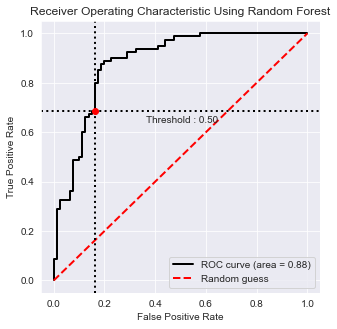

score is 0.8834375
0:00:09.989154


In [18]:
start = datetime.datetime.now()
rf = RandomForestClassifier(random_state=0)
parameters = param_grid = {'min_weight_fraction_leaf': [0.01, 0.1, 0.5],
                           'bootstrap': [True, False],
                           'max_depth': (2, 5, 10),
                           'max_leaf_nodes': (2, 5, 10),
                           'n_estimators': (100, 200)}
clf = GridSearchCV(rf, parameters, n_jobs=-1)
clf.fit(s12_sig_train, s12_y_train)
y_pred_proba = clf.predict_proba(s12_sig_test)[:,1]
y_pred = clf.predict(s12_sig_test)

bc = BinaryClassification(t12_y_test, y_pred_proba, labels=["Class 0", "Class 1"])
# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.title("Receiver Operating Characteristic Using Random Forest")
plt.show()
score = roc_auc_score(t12_y_test, y_pred_proba)
end = datetime.datetime.now()
print("score is " + str(score))
print(end-start)

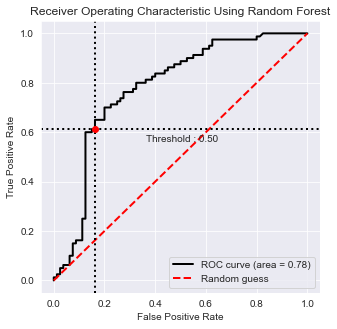

score is 0.7825781249999999


In [19]:
rf = RandomForestClassifier(random_state=0)
parameters = param_grid = {'min_weight_fraction_leaf': [0.01, 0.1, 0.5],
                           'bootstrap': [True, False],
                           'max_depth': (2, 5, 10),
                           'max_leaf_nodes': (2, 5, 10),
                           'n_estimators': (100, 200)}
clf = GridSearchCV(rf, parameters, n_jobs=-1)
clf.fit(s1_sig_train, s1_y_train)
y_pred_proba = clf.predict_proba(s1_sig_test)[:,1]
y_pred = clf.predict(s1_sig_test)

bc = BinaryClassification(t1_y_test, y_pred_proba, labels=["Class 0", "Class 1"])
# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.title("Receiver Operating Characteristic Using Random Forest")
plt.show()
score = roc_auc_score(t1_y_test, y_pred_proba)
print("score is " + str(score))

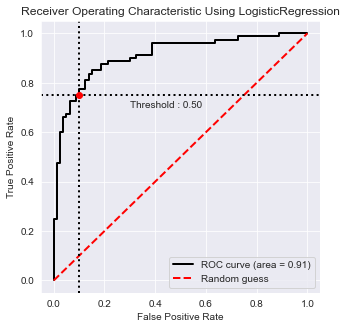

score is 0.910625
0:00:00.131120


In [20]:
start = datetime.datetime.now()
clf = LogisticRegression()
clf.fit(s12_sig_train, s12_y_train)
y_pred_proba = clf.predict_proba(s12_sig_test)[:,1]
y_pred = clf.predict(s12_sig_test)


bc = BinaryClassification(t12_y_test, y_pred_proba, labels=["Class 0", "Class 1"])
# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.title("Receiver Operating Characteristic Using LogisticRegression")
plt.show()
score = roc_auc_score(t12_y_test, y_pred_proba)
end = datetime.datetime.now()
print("score is " + str(score))
print(end-start)

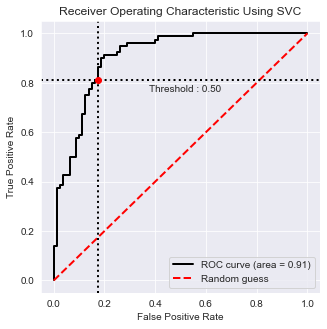

score is 0.90578125
0:00:00.209758


In [21]:
start = datetime.datetime.now()
clf = SVC(probability = True)
clf.fit(s12_sig_train, s12_y_train)
y_pred_proba = clf.predict_proba(s12_sig_test)[:,1]
y_pred = clf.predict(s12_sig_test)


bc = BinaryClassification(t12_y_test, y_pred_proba, labels=["Class 0", "Class 1"])
# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.title("Receiver Operating Characteristic Using SVC")
plt.show()
score = roc_auc_score(t12_y_test, y_pred_proba)
end = datetime.datetime.now()
print("score is " + str(score))
print(end-start)

In [22]:
for i in tqdm(range(3,20)):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(s12_sig_train, s12_y_train)
    y_pred = knn.predict(s12_sig_test)
    print(accuracy_score(t12_y_test, y_pred))

100%|██████████| 17/17 [00:00<00:00, 102.32it/s]

0.75625
0.7125
0.73125
0.69375
0.75
0.73125
0.725
0.70625
0.71875
0.7
0.7375
0.70625
0.7125
0.6875
0.69375
0.69375
0.69375


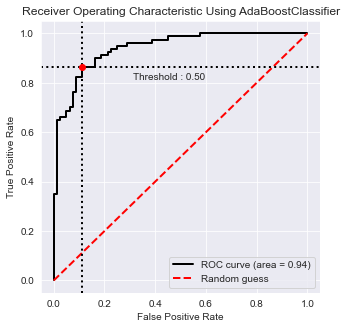

score is 0.94125
0:00:01.875881


In [23]:
start = datetime.datetime.now()
clf = AdaBoostClassifier()
clf.fit(s12_sig_train, s12_y_train)
y_pred_proba = clf.predict_proba(s12_sig_test)[:,1]
y_pred = clf.predict(s12_sig_test)


bc = BinaryClassification(t12_y_test, y_pred_proba, labels=["Class 0", "Class 1"])
# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.title("Receiver Operating Characteristic Using AdaBoostClassifier")
plt.show()
score = roc_auc_score(t12_y_test, y_pred_proba)
end = datetime.datetime.now()
print("score is " + str(score))
print(end-start)

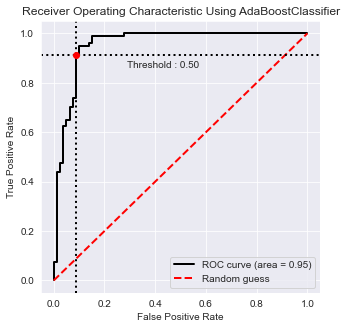

score is 0.95375
0:00:07.155698


In [24]:
start = datetime.datetime.now()
clf = GradientBoostingClassifier()
clf.fit(s12_sig_train, s12_y_train)
y_pred_proba = clf.predict_proba(s12_sig_test)[:,1]
y_pred = clf.predict(s12_sig_test)

bc = BinaryClassification(t12_y_test, y_pred_proba, labels=["Class 0", "Class 1"])
# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.title("Receiver Operating Characteristic Using AdaBoostClassifier")
plt.show()
score = roc_auc_score(t12_y_test, y_pred_proba)
end = datetime.datetime.now()
print("score is " + str(score))
print(end-start)